In [1]:
import numpy as np
import pylab as pb
import GPy

pb.ion()

In [2]:
# Edit this line to access a different backup file
backup_index = 99

X = np.load("hc_baby.npy", allow_pickle=True)
Y = np.log(np.load("samples_baby.npy", allow_pickle=True))

In [3]:
X_raw = np.load("hc_demo2.npy", allow_pickle=True)
Y_raw = np.log(np.load("samplesC2_backup_i" + str(backup_index) + ".npy",
    allow_pickle=True))

 /tmp/ipykernel_18594/738058729.py:2: RuntimeWarning:divide by zero encountered in log


In [4]:
# We have to truncate the matrices a little because they use the shapes of the
# final products, meaning a lot of unfilled cells
X_truncated = X_raw[:backup_index]
Y_truncated = Y_raw[:backup_index]
# Possible off-by-one error here, but in this case that just means we're
# excluding one sample.

In [5]:
scale_factor = np.load("standard_k.npy", allow_pickle=True)

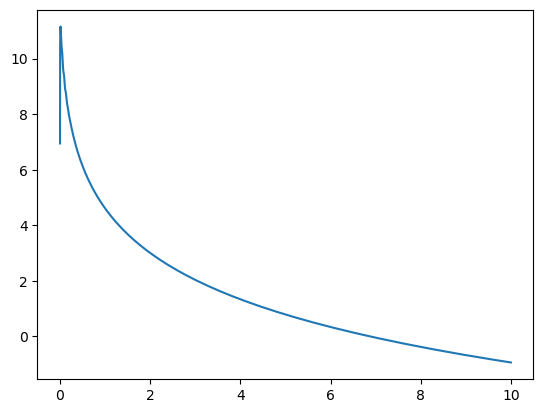

In [6]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scale_factor, Y_truncated[0])

In [7]:
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if float('-inf') in pspec:
        print("-inf")
    if float('inf') in pspec:
        print("inf")
    if None in pspec:
        print("None")
    if True in np.isnan(pspec):
        print("NaN in row", i)
        print(X_truncated[i])
    if 0 in pspec:
        print("zero")

NaN in row 15
[2.14507500e-02 5.25215000e-02 9.30714000e-01 7.56880000e-01
 4.84900000e-03 1.38632966e-09]
NaN in row 36
[2.11327500e-02 1.68346500e-01 9.02634000e-01 9.59280000e-01
 5.04300000e-03 1.49589886e-09]
NaN in row 47
[2.19067500e-02 9.04055000e-02 8.51050000e-01 8.41680000e-01
 4.24700000e-03 3.80079345e-09]
NaN in row 48
[2.22652500e-02 8.24515000e-02 1.08453000e+00 8.56720000e-01
 2.04300000e-03 3.36803452e-09]
NaN in row 52
[2.29837500e-02 5.35465000e-02 1.02686200e+00 7.40880000e-01
 2.25000000e-04 4.63951023e-09]
NaN in row 54
[2.41972500e-02 1.10987500e-01 9.14802000e-01 7.41040000e-01
 9.54700000e-03 2.32594469e-09]
NaN in row 55
[2.01787500e-02 5.91635000e-02 9.56506000e-01 4.89520000e-01
 7.36100000e-03 1.57078429e-09]
NaN in row 61
[2.09062500e-02 7.64245000e-02 1.04792200e+00 5.12560000e-01
 9.90300000e-03 1.08284662e-09]
NaN in row 63
[2.12362500e-02 9.72115000e-02 1.08817000e+00 7.52880000e-01
 9.45700000e-03 2.03192086e-09]
NaN in row 64
[2.44642500e-02 7.40465

In [8]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_truncated, bad_row_indices, 0)
Y = np.delete(Y_truncated, bad_row_indices, 0)

'''
# Now remove the offending rows
for i in reversed(bad_row_indices):
    # iterate backwards or else concurrent modification
    # makes the indices meaningless
    X.pop(i)
    Y.pop(i)
'''

'\n# Now remove the offending rows\nfor i in reversed(bad_row_indices):\n    # iterate backwards or else concurrent modification\n    # makes the indices meaningless\n    X.pop(i)\n    Y.pop(i)\n'

In [9]:
print(X.shape, Y.shape)

(79, 6) (79, 300)


In [10]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

In [11]:
m.constrain_positive('') # '' is a regex matching all parameter names
m.optimize()

In [12]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, 2.12723788013000E-09
])])
x

array([[2.24450000e-02, 1.20567000e-01, 9.60000000e-01, 8.24667740e-01,
        0.00000000e+00, 2.12723788e-09]])

In [13]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale factor k')

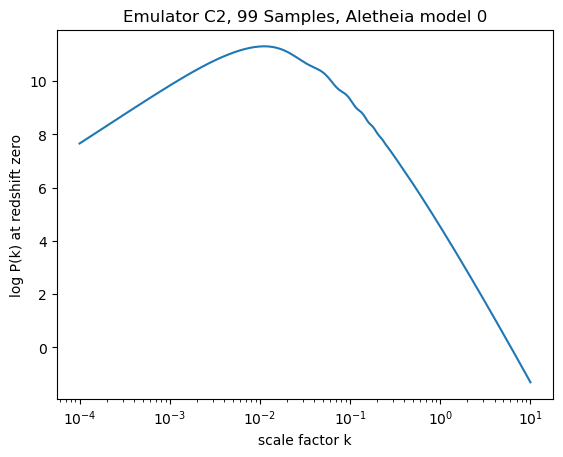

In [14]:
#import matplotlib.pyplot as plt
pb.plot(scale_factor, guess[0])
pb.title("Emulator C2, 99 Samples, Aletheia model 0")
pb.xscale('log')
pb.ylabel('log P(k) at redshift zero')
pb.xlabel('scale factor k')

In [15]:
# Now let's check our work with battery
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

# Compare like to like
mlc = spectra.specify_neutrino_mass(spectra.cosm.iloc[0], 0, 0)
k_m0truth, z_m0truth, p_m0truth, s_m0truth = \
    spectra.kzps(mlc, [0], k_points=300, hubble_units=False)
print(s_m0truth)

[0.82466774]


Next steps:
* Import "ground truth": what the plot was really supposed to look like for model 0
* Play with omega_nu, n_s, omega_nu + omega_cdm to see if you can get the same behavior as in the animations

Text(0.5, 0, 'scale factor k')

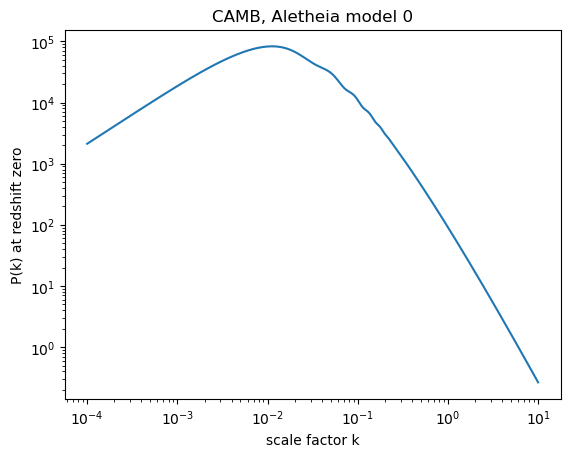

In [16]:
#import matplotlib.pyplot as plt
pb.loglog(k_m0truth, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale factor k')

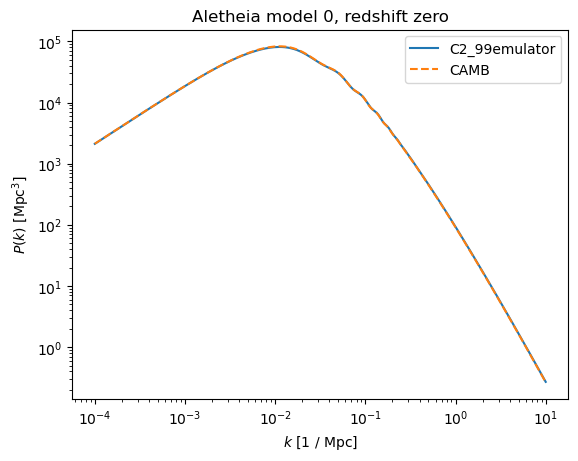

In [27]:
pb.plot(scale_factor, np.exp(guess[0]), label="C2_" + str(backup_index) + "emulator")
pb.loglog(k_m0truth, p_m0truth, label="CAMB", linestyle="dashed")
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('$k$ [1 / Mpc]')
pb.legend()

In [18]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.1, 0.82466774, 0, 2.12723788013000E-09
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.84, 0.82466774, 0, 2.12723788013000E-09
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


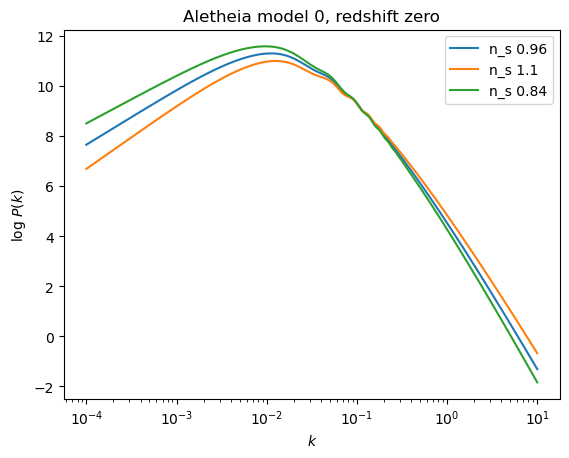

In [19]:
pb.plot(scale_factor, guess[0], label="n_s 0.96")
pb.plot(scale_factor, guess_hi_ns[0], label="n_s 1.1")
pb.plot(scale_factor, guess_lo_ns[0], label="n_s 0.84")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [20]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774, omnu_hi,\
    2.12723788013000E-09
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(x_hi_omnu)

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774, omnu_mid, \
    2.12723788013000E-09
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(x_mid_omnu)


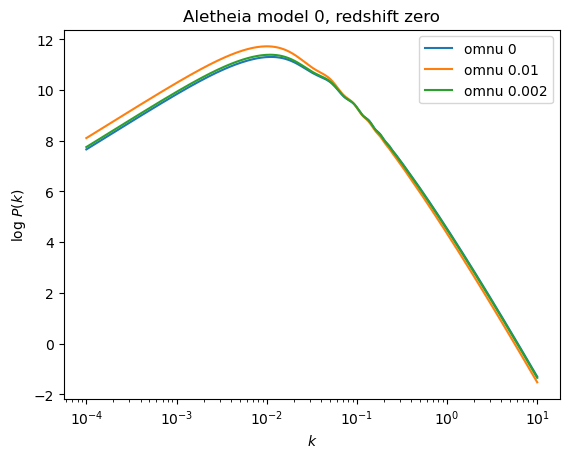

In [21]:
pb.plot(scale_factor, guess[0], label="omnu 0")
pb.plot(scale_factor, guess_hi_omnu[0], label="omnu 0.01")
pb.plot(scale_factor, guess_mid_omnu[0], label="omnu 0.002")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [22]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
hi_factor = 1.15
x_hi_omm = np.array([np.array([
    0.022445 * hi_factor, 0.120567 * hi_factor, 0.96, 0.82466774, 0,\
    2.12723788013000E-09
])])
guess_hi_omm, uncertainties_hi_omm = m.predict(x_hi_omm)

lo_factor = 0.85
x_lo_omm = np.array([np.array([
    0.022445 * lo_factor, 0.120567 * lo_factor, 0.96, 0.82466774, 0, \
    2.12723788013000E-09
])])
guess_lo_omm, uncertainties_lo_omm = m.predict(x_lo_omm)


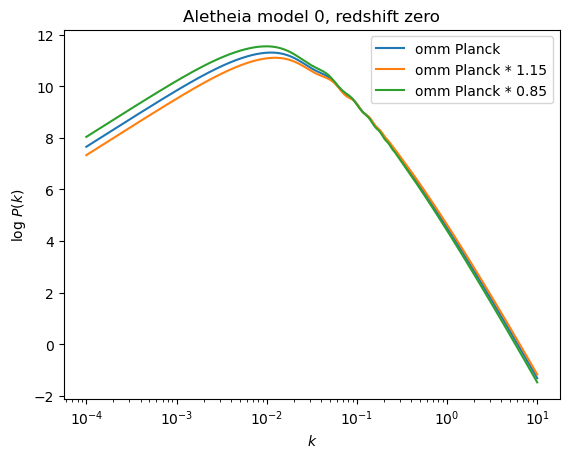

In [23]:
pb.plot(scale_factor, guess[0], label="omm Planck")
pb.plot(scale_factor, guess_hi_omm[0], label="omm Planck * 1.15")
pb.plot(scale_factor, guess_lo_omm[0], label="omm Planck * 0.85")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [24]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(3.91) / 10 ** 10
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(2.35) / 10 ** 10 
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

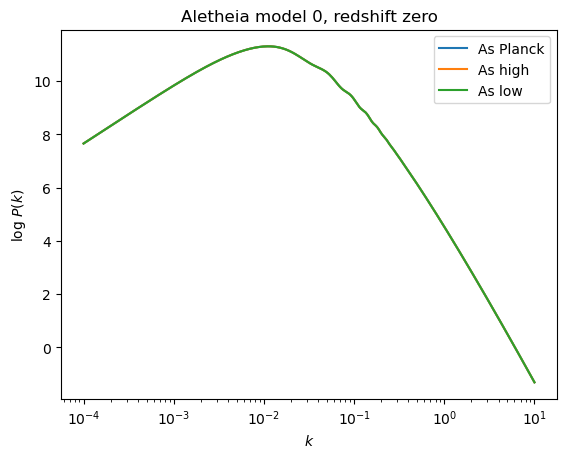

In [25]:
pb.plot(scale_factor, guess[0], label="As Planck")
pb.plot(scale_factor, guess_hi_As[0], label="As high")
pb.plot(scale_factor, guess_lo_As[0], label="As low")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

I guess this shows that sigma12 countermands As, huh?